#### 5 year Forecasting With Online Sales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [4]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [6]:
online_channel= df.loc[df['Region'] == 'Australia',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
4,2011-05-31,Online,3399.99,Australia
6,2011-06-01,Online,3578.27,Australia
7,2011-06-01,Online,3374.99,Australia
8,2011-06-01,Online,3399.99,Australia
12,2011-06-02,Online,3578.27,Australia
...,...,...,...,...
60322,2014-06-30,Online,3.99,Australia
60323,2014-06-30,Online,3.99,Australia
60324,2014-06-30,Online,32.60,Australia
60325,2014-06-30,Online,120.00,Australia


### Data Preprocessing

In [7]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [8]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,3399.9900
1,2011-06-01,10353.2500
2,2011-06-02,7156.5400
3,2011-06-04,7855.6382
4,2011-06-06,3578.2700
...,...,...
1053,2014-06-26,300.9000
1054,2014-06-27,274.9800
1055,2014-06-28,95.4700
1056,2014-06-29,324.9800


### Indexing with Time Series Data

In [9]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-06-01', '2011-06-02', '2011-06-04',
               '2011-06-06', '2011-06-07', '2011-06-08', '2011-06-09',
               '2011-06-10', '2011-06-11',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='OrderDate', length=1058, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [10]:
y = online_channel['Total_Sales'].resample('MS').mean()
##y = y.fillna(y.bfill())

In [11]:
y['2014':]

OrderDate
2014-01-01    14033.074839
2014-02-01    12684.657857
2014-03-01    15116.696129
2014-04-01    13770.552667
2014-05-01    15476.342258
2014-06-01      300.416667
Freq: MS, Name: Total_Sales, dtype: float64

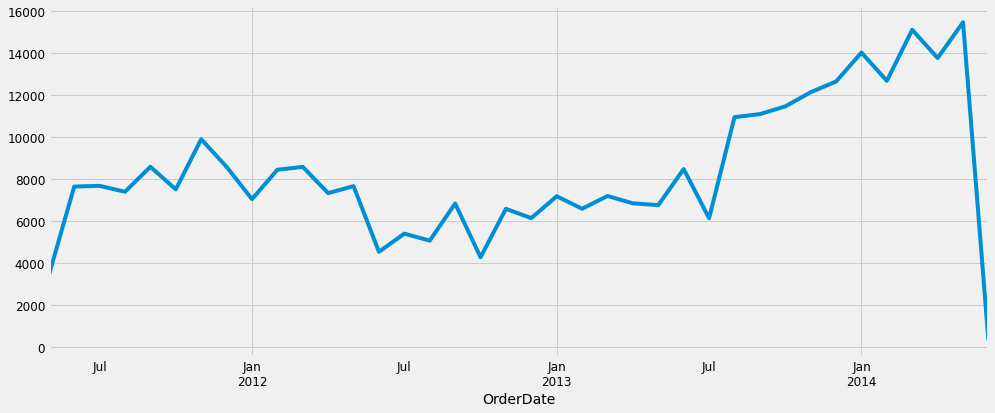

In [12]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

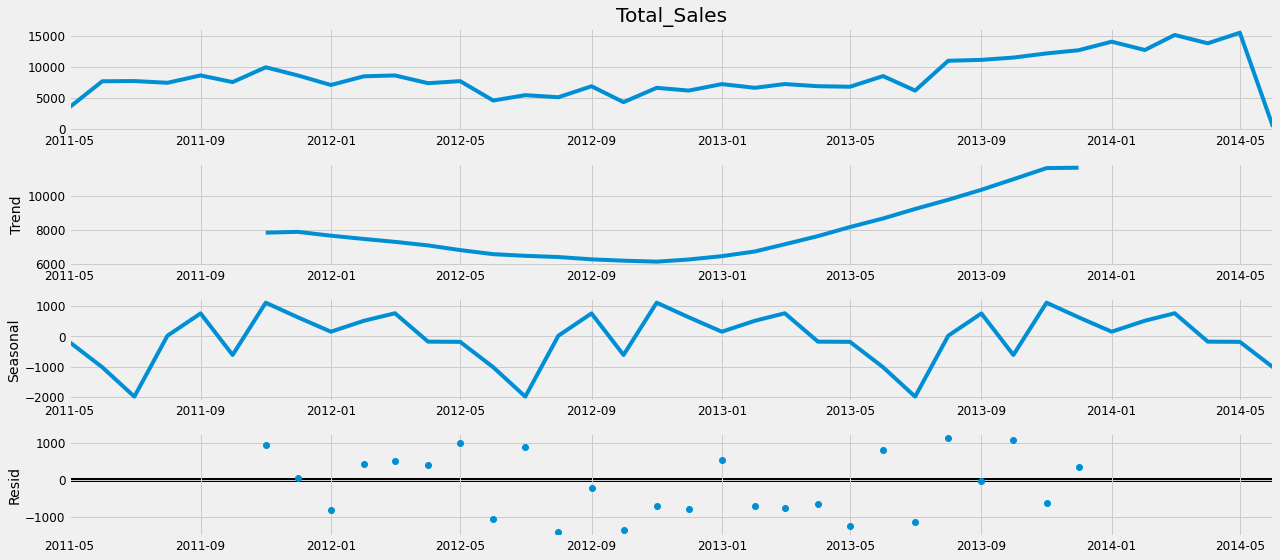

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [15]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:781.3881039989428
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1237.1486333747966
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:497.3683268313709
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:271.99673466763977
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:517.6437846393128
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:502.7491336817648
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:277.27505357803324
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:249.7771350886782
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:736.004138951309
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2639.301744845318
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:478.61699678205866
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:247.5261659696743
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:513.2540209382882
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:465.8722457429278
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:273.29783879030975
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:231.88695042054005
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:680.319566279957
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1051.8410390183394
ARIMA

 ### Fitting an ARIMA Time Series Model

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1042      0.538     -0.194      0.846      -1.159       0.950
ma.L1         -1.0042      2.425     -0.414      0.679      -5.757       3.749
ar.S.L12      -1.8420      0.521     -3.538      0.000      -2.863      -0.822
ma.S.L12       1.2853      2.233      0.575      0.565      -3.092       5.663
sigma2      2.545e+06    6.1e-07   4.18e+12      0.000    2.55e+06    2.55e+06


### Validating forecasts

In [17]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


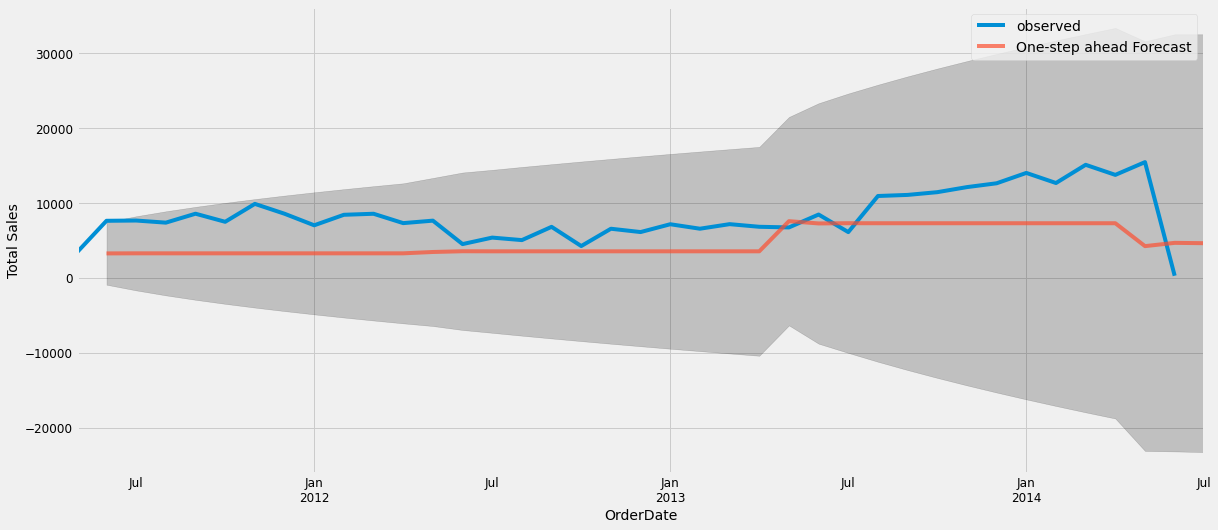

In [18]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-06-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 19282555.1


In [23]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4391.19


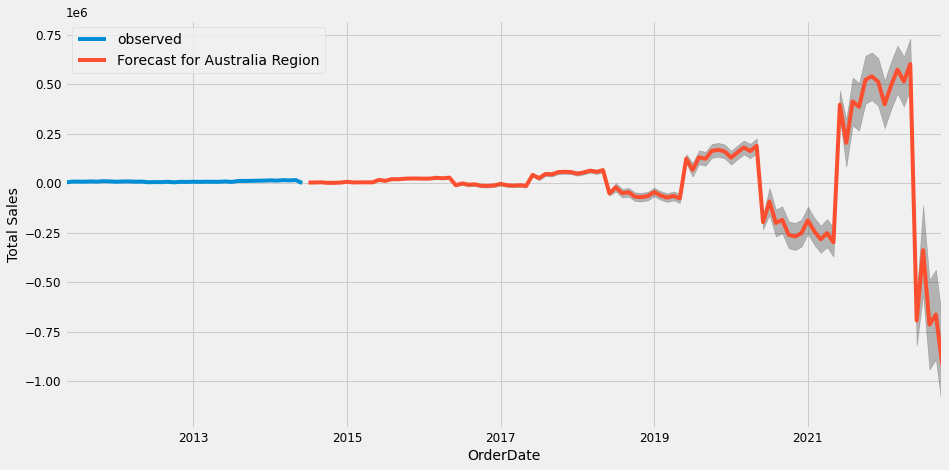

In [24]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for Australia Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()